# Annotated directions analysis

In [1]:
import json
import numpy as np
import os
import pandas as pd
import requests

import matplotlib.pyplot as plt
%matplotlib inline

## 1 &emsp; Preparation

Gathering paths to plays' `.csv` files and their IDs (which are basically author's name and play title):

In [ ]:
# if you're doing this for the first time — run everything until Part 3
path_to_annot = "./data/stage/annotated/"
plays_csv = [play_id for play_id in os.listdir(path_to_annot) 
             if play_id != ".DS_Store"]
play_paths = [path_to_annot + play_id for play_id in plays_csv]
play_ids = [play_csv[:-4] for play_csv in plays_csv]

### 1.1 &emsp; Data not present in .csv

Additional functions: adding year of the play and `play_id`:

Extracting **year of the play**, fetched from corpus metadata:

In [ ]:
request_link = "https://dracor.org/api/corpora/rus/metadata"
response = requests.get(request_link)
if response.status_code == 200:
    play_metadata = response.json()

In [ ]:
def append_play_year(play_id, play_metadata):
    """Using metadata from DraCor API, extracts yearNormalized
    for the play.
    
    Calculation of yearNormalized:
    > if date_print and date_premiere:
    >     yearNormalized = min(date_print, date_premiere)
    > elif date_premiere:
    >     yearNormalized = date_premiere
    > else:
    >     yearNormalized = date_print
    > if date_written and yearNormalized:
    >     if yearNormalized - date_written > 10:
    >         yearNormalized = date_written
    >     elif date_written and not yearNormalized:
    >         yearNormalized = date_written
    
    :args play_id (str) — author's name and title of the play
    play_metadata (json) — metadata for all the plays currently
    present in the corpus
    
    :returns year (int) — normalized year of the play
    """
    
    for play in play_metadata:
        if play["playName"] == play_id:
            year = int(play["yearNormalized"])
            break
        else:
            year = 0
    if year == 0:
        print("Couldn't retrieve year.\n\t- play: {}\n\t- status code: {} \
            \n=> Returning 0".format(play_id, response.status_code))
    return year

## 2 &emsp; Assembling everything together

In [ ]:
def csv_to_full_df(play_id):
    """Converts .csv files for /data/stage/annotated into a 
    pd.DataFrame, then adds 
        (1) directions' origin, 
        (2) normalized year of the play (see append_play_year()).
            
    :args play_id (str) — author's name and title of the play
    
    :returns play_df (pd.DataFrame) — converted data of a single play
    """
    
    play_csv_path = "./data/stage/annotated/{}.csv".format(play_id)
    play_df = pd.read_csv(play_csv_path, sep=";", encoding="utf-8").fillna(0)
    
    # convert direction marks to categories
    for dir_type in play_df.columns[1:]:
        play_df[dir_type] = play_df[dir_type].astype("category")
    
    # add play_id so that we know directions' origin
    add_play_name = lambda play_id : play_id
    play_df["play"] = [add_play_name(play_id)] * len(play_df)
    
    # add yearNormalized
    play_df["year"] = [append_play_year(play_id, play_metadata)] * len(play_df)
    
    return play_df

Concatenating all plays in a single dataset:

In [ ]:
df_total = pd.DataFrame(columns=["text", "setting", "entrance", "exit", "business", "delivery", 
                                 "modifier", "location", "unknown", "play", "year"])

In [ ]:
for play_id in play_ids:
    play_df = csv_to_full_df(play_id)
    df_total = pd.concat([df_total, play_df], ignore_index=True)

Sanity checks:

In [ ]:
# dataframe columns
df_total.head()

In [ ]:
# amount of directions
df_total[df_total["play"] == "lermontov-maskarad"]["text"].count()

In [ ]:
len(df_total)

In [ ]:
df_total["play"]

## 3 &emsp; Saving

This data is raw — we haven't done any analysis yet. Nevertheless, it might be useful to save it for later research.

In [2]:
# run to_csv if this is the first time you're running the notebook
# df_total.to_csv("./data/csv/annot_merged_raw.csv", sep=";", encoding="utf-8", index=False)
# otherwise run read_csv
df_total = pd.read_csv("./data/csv/annot_merged_raw.csv", 
                       sep=";", encoding="utf-8")
df_total.head()

,text,setting,entrance,exit,business,delivery,modifier,location,unknown,play,year
0,"Игроки, князь Звездич, Казарин и Шприх. За сто...",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,lermontov-maskarad,1842
1,(тихо первому),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,lermontov-maskarad,1842
2,(насмешливо),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,lermontov-maskarad,1842
3,"(сквозь зубы, уходя)",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,lermontov-maskarad,1842
4,"Князь, выпив стакан лимонаду, садится к сторон...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,lermontov-maskarad,1842


## 4 &emsp; Directions distribution among plays

### 4.1 &emsp; How many directions are there in the plays year-wise?

In [3]:
direction_types = ["setting", "entrance", "exit", "business", "delivery", 
                   "modifier", "location", "unknown"]
plays = df_total["play"].unique()

dict_plays = {
    "play": [], 
    "year": [], 
    "amount": []
}
for play in plays:
    try:
        dict_plays["play"].append(play)
        dict_plays["year"].append(df_total[df_total["play"] == play]["year"].unique()[0])
        amount = df_total[df_total["play"] == play]["text"].count()
        dict_plays["amount"].append(amount)
    except:
        print(play)

In [4]:
df_plays = pd.DataFrame.from_dict(dict_plays).sort_values(by=["year"]).reset_index(drop=True)
df_plays.head()

,play,year,amount
0,sumarokov-horev,1747,33
1,fonvizin-nedorosl,1782,349
2,krylov-urok-dochkam,1807,146
3,griboyedov-gore-ot-uma,1825,209
4,pushkin-boris-godunov,1831,172


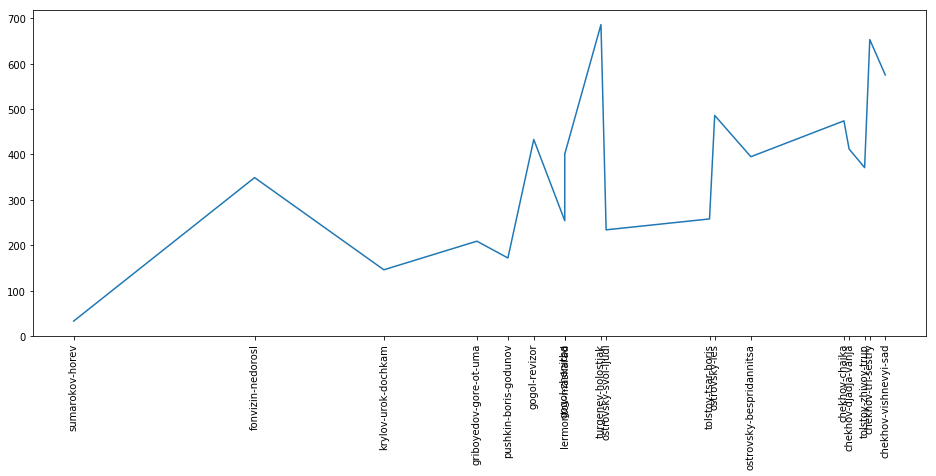

In [5]:
plt.figure(figsize=(16,6))
plt.xticks(df_plays["year"], labels=df_plays["play"], rotation=90)
plt.plot(df_plays["year"], df_plays["amount"])

### 4.2 &emsp; What are the proportions of different types in the plays?

First, we have to gather the data, i.e. to sum up all the types for a certain play.

In [6]:
types_dict = {
    dir_type: [] for dir_type in direction_types + ["play", "year"]
}
for i, play in enumerate(plays):
    types_dict["play"].append(play)
    types_dict["year"].append(dict_plays["year"][i])
    types_values = df_total[df_total["play"] == play].sum()[direction_types]
    for ty in types_values.keys():
        types_dict[ty].append(types_values[ty])

In [7]:
df_types = pd.DataFrame.from_dict(types_dict).sort_values(by=["year"]).reset_index().set_index("play")
df_types.head()

,index,setting,entrance,exit,business,delivery,modifier,location,unknown,year
play,,,,,,,,,,
sumarokov-horev,9,0.0,26.0,1.0,4.0,1.0,0.0,0.0,1.0,1747
fonvizin-nedorosl,7,0.0,46.0,22.0,151.0,133.0,9.0,3.0,5.0,1782
krylov-urok-dochkam,1,0.0,21.0,11.0,73.0,45.0,0.0,2.0,1.0,1807
griboyedov-gore-ot-uma,3,3.0,39.0,29.0,83.0,61.0,0.0,9.0,0.0,1825
pushkin-boris-godunov,17,9.0,37.0,22.0,89.0,23.0,0.0,6.0,1.0,1831


<Figure size 1152x432 with 0 Axes>

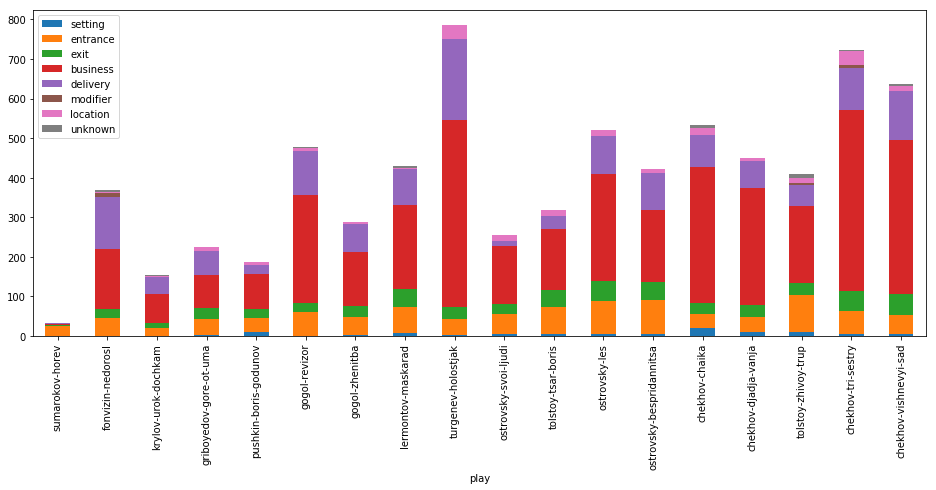

In [8]:
plt.figure(figsize=(16,6))
df_types[direction_types].plot.bar(stacked=True, figsize=(16,6))

### 4.3 &emsp; Type distribution

Which types are more frequent and which are not present?

In [3]:
direction_types = ["setting", "entrance", "exit", "business", "delivery", 
                   "modifier", "location", "unknown"]

In [5]:
types_dict = {}

for dir_type in direction_types:
    type_count = df_total[dir_type].sum()
    types_dict[dir_type] = type_count

In [13]:
x = []
plot_labels = []

for i, dir_type in enumerate(types_dict):
    x.append(i)
    plot_labels.append(dir_type)

height = [types_dict[dirtype] for dirtype in plot_labels]

<BarContainer object of 8 artists>

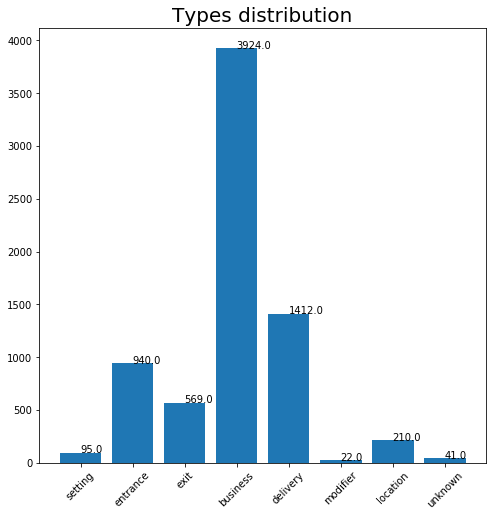

In [31]:
plt.figure(figsize=(8,8))
for i, v in enumerate(height):
    plt.text(x[i], v, str(v))
plt.title("Types distribution", fontsize=20)
plt.xticks(x, plot_labels, rotation=45)
plt.bar(x, height)